<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [138]:
# !pip install --upgrade --no-cache-dir gdown --quiet

In [139]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [140]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [141]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [142]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [143]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()


Rating
4    12540
3     4908
2     2823
1     1549
0      821
Name: count, dtype: int64

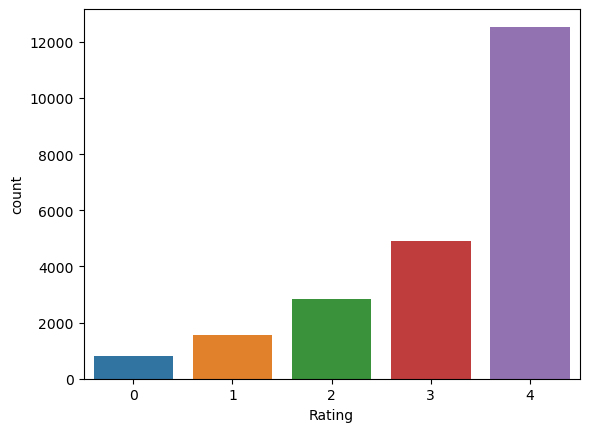

In [144]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [145]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [146]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [147]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [148]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [149]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [150]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [151]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [152]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [153]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [154]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [155]:
sequences[0][:10]

[253, 532, 917, 3, 662, 3, 68]

In [156]:
# Alumno: Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')


el máximo es 115


(array([ 21.,  15.,  26.,  22.,  39.,  54.,  78., 293., 147., 132., 189.,
        168., 195., 188., 180., 389., 204., 227., 225., 229., 240., 227.,
        254., 504., 249., 265., 243., 289., 238., 257., 503., 262., 278.,
        268., 287., 306., 258., 243., 494., 269., 252., 227., 266., 230.,
        229., 243., 506., 257., 231., 224., 236., 231., 229., 464., 212.,
        222., 220., 223., 204., 195., 195., 399., 171., 200., 197., 171.,
        186., 191., 178., 412., 206., 215., 244., 201., 255., 287., 600.,
        317., 350., 368., 367., 390., 346., 313., 639., 247., 246., 194.,
        144., 113.,  71.,  50.,  75.,  20.,   7.,  12.,   2.,   4.,   1.,
          1.]),
 array([  2.  ,   3.13,   4.26,   5.39,   6.52,   7.65,   8.78,   9.91,
         11.04,  12.17,  13.3 ,  14.43,  15.56,  16.69,  17.82,  18.95,
         20.08,  21.21,  22.34,  23.47,  24.6 ,  25.73,  26.86,  27.99,
         29.12,  30.25,  31.38,  32.51,  33.64,  34.77,  35.9 ,  37.03,
         38.16,  39.29,  40.42

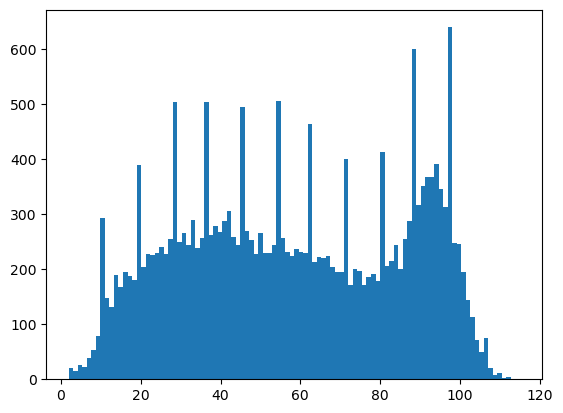

In [157]:
plt.figure()
plt.hist(seqs_lenght,bins=100)

In [158]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [159]:
(np.array(seqs_lenght)<maxlen).mean()

0.999955832339561

In [160]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [161]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y = pd.get_dummies(df_reviews['Rating']).values
print(y.shape)
print(y)

(22641, 5)
[[False False False  True False]
 [False False False False  True]
 [False False  True False False]
 ...
 [False False  True False False]
 [False False  True False False]
 [False False False False  True]]


In [162]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [163]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 #Multiclass classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [164]:
#Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.

##### Usaré Fasttext + LSTM

In [165]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0  33.3M      0  0:01:22  0:01:22 --:--:-- 30.9M22 35.1M:22  0:00:21  0:01:01 34.9M   0     0  33.3M      0  0:01:22  0:00:25  0:00:57 34.4M0:00:27  0:00:55 33.4M  0  33.3M      0  0:01:22  0:01:22 --:--:-- 30.9M5M


In [166]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [167]:
model_fasttext = FasttextEmbeddings()
# Mirar cómo sube el uso de RAM en colab!

In [168]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [169]:
# Definimos el modelo
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape, weights=[embedding_matrix], trainable=False))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))  # Adjust units and activation

model.compile(optimizer="adam",
              loss='categorical_crossentropy',  # Update loss function
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_8 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_8 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                

In [170]:
hist = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 37s 73ms/step - loss: 1.2342 - accuracy: 0.5491 - val_loss: 1.1998 - val_accuracy: 0.5551
Epoch 2/20
453/453 [==============================] - 33s 74ms/step - loss: 1.1846 - accuracy: 0.5512 - val_loss: 1.1460 - val_accuracy: 0.5573
Epoch 3/20
453/453 [==============================] - 33s 73ms/step - loss: 1.1501 - accuracy: 0.5534 - val_loss: 1.1206 - val_accuracy: 0.5592
Epoch 4/20
453/453 [==============================] - 33s 72ms/step - loss: 1.1258 - accuracy: 0.5586 - val_loss: 1.1074 - val_accuracy: 0.5603
Epoch 5/20
453/453 [==============================] - 33s 72ms/step - loss: 1.1080 - accuracy: 0.5606 - val_loss: 1.0967 - val_accuracy: 0.5691
Epoch 6/20
453/453 [==============================] - 33s 73ms/step - loss: 1.0913 - accuracy: 0.5665 - val_loss: 1.0843 - val_accuracy: 0.5725
Epoch 7/20
453/453 [==============================] - 34s 74ms/step - loss: 1.0716 - accuracy: 0.5702 - val_loss: 1.0857 - val_accuracy:

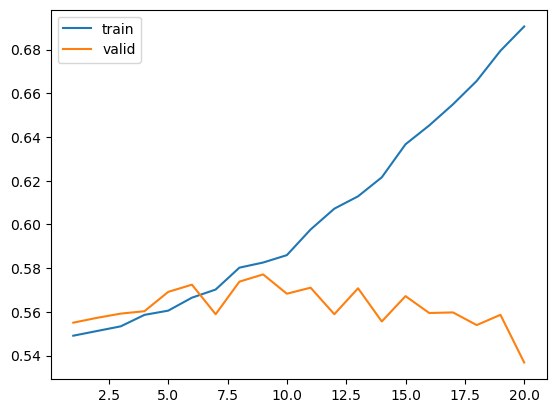

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [172]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 3s 22ms/step - loss: 1.3049 - accuracy: 0.5390


[1.3049355745315552, 0.5389710664749146]

### Conclusion por ahora: 
##### * Con 5 epochs -> loss: 1.1063 - accuracy: 0.5756 
##### * Con 20 epochs -> loss: 1.3049 - accuracy: 0.5390

## Test incrementando complejidad de modelo, agregando pesos a las clases y 30 epochs

In [192]:
total_muestras = 12540 + 4908 + 2823 + 1549 + 821
num_clases = 5

muestras_clase = [ 821, 1549, 2823, 4908, 12540]
pesos_clase = {}

for i, muestras in enumerate(muestras_clase):
    peso = total_muestras / (num_clases * muestras)
    pesos_clase[i] = peso

print(pesos_clase)

{0: 5.515468940316687, 1: 2.9233053582956745, 2: 1.60403825717322, 3: 0.9226161369193154, 4: 0.36110047846889953}


In [193]:
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape, weights=[embedding_matrix], trainable=False))
model2.add(LSTM(units=128, return_sequences=True))  # Aumentar unidades de LSTM
model2.add(Dropout(0.2))
model2.add(LSTM(units=128))  # Aumentar unidades de LSTM
model2.add(Dense(units=256, activation='relu'))  # Aumentar unidades de Dense
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))  # Ajustar unidades y activación

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 115, 300)          600000    
                                                                 
 lstm_20 (LSTM)              (None, 115, 128)          219648    
                                                                 
 dropout_20 (Dropout)        (None, 115, 128)          0         
                                                                 
 lstm_21 (LSTM)              (None, 128)               131584    
                                                                 
 dense_20 (Dense)            (None, 256)               33024     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 5)               

In [194]:
hist2 = model2.fit(X_train, y_train, epochs=30, validation_split=0.2, class_weight = pesos_clase)

Epoch 1/30
453/453 [==============================] - 73s 158ms/step - loss: 1.6094 - accuracy: 0.2183 - val_loss: 1.5706 - val_accuracy: 0.2622
Epoch 2/30
453/453 [==============================] - 71s 157ms/step - loss: 1.5765 - accuracy: 0.3263 - val_loss: 1.4423 - val_accuracy: 0.3991
Epoch 3/30
453/453 [==============================] - 70s 153ms/step - loss: 1.5363 - accuracy: 0.3804 - val_loss: 1.4651 - val_accuracy: 0.4027
Epoch 4/30
453/453 [==============================] - 69s 153ms/step - loss: 1.5110 - accuracy: 0.3818 - val_loss: 1.3960 - val_accuracy: 0.4071
Epoch 5/30
453/453 [==============================] - 71s 157ms/step - loss: 1.4889 - accuracy: 0.3929 - val_loss: 1.6730 - val_accuracy: 0.2799
Epoch 6/30
453/453 [==============================] - 68s 150ms/step - loss: 1.4590 - accuracy: 0.4109 - val_loss: 1.4018 - val_accuracy: 0.4182
Epoch 7/30
453/453 [==============================] - 69s 152ms/step - loss: 1.4296 - accuracy: 0.4151 - val_loss: 1.3771 - val_ac

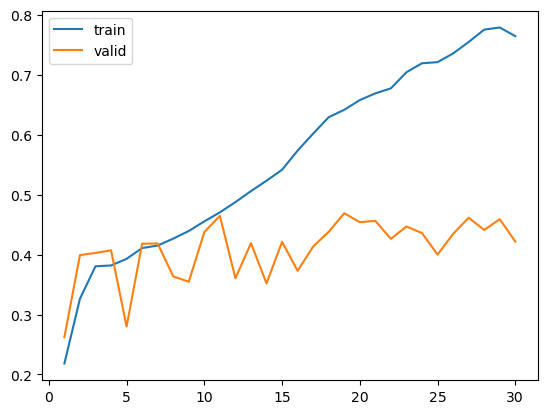

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [196]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 6s 44ms/step - loss: 2.3666 - accuracy: 0.4314


[2.366612672805786, 0.4314418137073517]

### 4 - Conclusión 

##### Al realizar el analisis sin agregar pesos a las entradas (ya que estan desbalanceadas) se ve que si bien la accuracy tiene un valor de 0.5 aproxiadamente, el modelo no responde de forma correcta, si bien al commienzo los valores de validación siguen a los de train, luego tienden a descender.
##### Por otra parte, agregando el parametro de balanceo en class_weight se nota una mejora en los resultados graficos de entrenamiento, sin embargo no se detecta una mejora en la accuracy, manteniendose en valores similares.

##### Para mejorar estos resultados, se puede pensar en mejorar
##### * etapa de pre-procesamiento, calculando mejor los pesos si es necesario o agrandando el dataset
##### * incrementar la complejidad del modelo, agregando mas neuronas, expandiendo embeddings, etc.

